In [6]:
import convex_return_mapping as crm # there is a conflict in the oder of imported modules

import meshio
from mpi4py import MPI

import plasticity_framework as pf
import sys
sys.path.append("../")
import fenicsx_support as fs
# from dolfinx import fem, io

import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_dsiplacement(points_on_proc, results):
    if len(points_on_proc) > 0:
        plt.plot(results[:, 0], results[:, 1], "-o")
        plt.xlabel("Displacement of inner boundary")
        plt.ylabel(r"Applied pressure $q/q_{lim}$")
        plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
        plt.show()

In [8]:
Pa_dim = 70e3
E = 70e3 / Pa_dim #[-]
nu = 0.3 #[-]

sig0 = 250 / Pa_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

alpha = 0.01
vonMises = crm.vonMises(sig0, H)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material_vM = crm.Material(crm.IsotropicElasticity(E, nu), vonMises)
material_DP = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 0.041 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.041 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.041 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.626615748929017e-18, 1.5199511177971175e-13
u 0.001988243836511538 0.0 0.02393720100673146
rank#0: Time (mean return mapping) = 0.035 (s)

nRes0 , 2.10211537593027e-05 
 Increment: 5, load = 0.000567390898726805

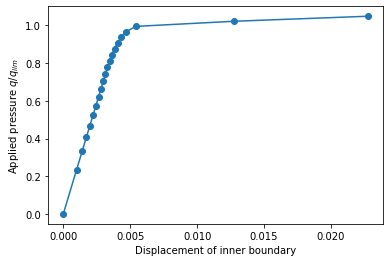

In [9]:
plasticity = pf.StandardDPPlasticity(material_DP, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results = plasticity.solve()
plot_dsiplacement(points_on_proc, results)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 7.350540377431972e-16, 8.254671557515993e-12
u 0.0009941219182566228 0.0 0.011968600503365713
rank#0: Time (mean return mapping) = 2.259 (s)

nRes0 , 3.688449012011855e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 9.938144639955788e-13, 2.694396644115477e-08
    Residual: 2.121811665660268e-18, 5.752585053366188e-14
u 0.0014059006994511696 0.0 0.016926157154483795
rank#0: Time (mean return mapping) = 2.332 (s)

nRes0 , 2.8302464707225196e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 1.4906686210240657e-12, 5.266921578895284e-08
    Residual: 1.811049385818189e-18, 6.398910499677631e-14
u 0.0017218696713395363 0.0 0.020730224167321294
rank#0: Time (mean return mapping) = 2.103 (s)

nRes0 , 2.3860081462259148e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 1.734167446725519e-12, 7.26807010055079e-08
    Residual: 1.7016057085929112e-18, 7.1316005826

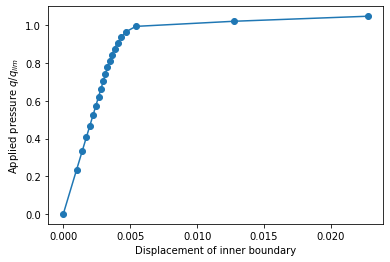

In [10]:
plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
    Residual: 1.2147131367345928e-17, 1.3641252840579853e-13
u 0.0009941219182568394 0.0 0.01196860050336559
rank#0: Time (mean return mapping) = 0.045 (s)

nRes0 , 3.688449012039698e-05 
 Increment: 2, load = 0.00035884951272532715
    Residual: 5.307352153800226e-18, 1.438911622873507e-13
u 0.0014059006994499425 0.0 0.01692615715448523
rank#0: Time (mean return mapping) = 0.037 (s)

nRes0 , 2.830246470722443e-05 
 Increment: 3, load = 0.0004394991003117152
    Residual: 4.262305546269069e-18, 1.5059838746768517e-13
u 0.0017218696713369305 0.0 0.020730224167323872
rank#0: Time (mean return mapping) = 0.039 (s)

nRes0 , 2.3860081462258555e-05 
 Increment: 4, load = 0.0005074898477471342
    Residual: 3.626615748929017e-18, 1.5199511177971175e-13
u 0.001988243836511538 0.0 0.02393720100673146
rank#0: Time (mean return mapping) = 0.053 (s)

nRes0 , 2.10211537593027e-05 
 Increment: 5, load = 0.000567390898726805

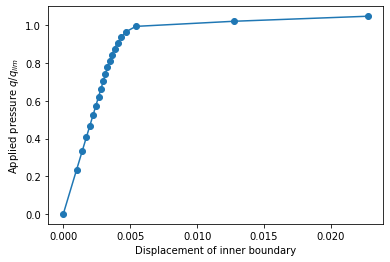

In [11]:
plasticity_vM = pf.StandardPlasticity(material_vM, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_vM = plasticity_vM.solve()
plot_dsiplacement(points_on_proc, results_vM)

In [5]:
plasticity_convex = pf.ConvexPlasticity(material_DP, patch_size=3, mesh_name="thick_cylinder_coarse.msh")
points_on_proc, results_convex = plasticity_convex.solve()
plot_dsiplacement(points_on_proc, results_convex)



nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
    Residual: 7.331495113968809e-16, 8.23328368852374e-12
rank#0: Time (mean return mapping) = 2.438 (s)

nRes0 , 3.688449012011849e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787795453017 0.0 0.004957556638609557
    Residual: 6.035285834575204e-13, 1.6362665757126145e-08
du 1.7022107518300863e-12 -3.1047696077529896e-14 1.4455349779938658e-11
    Residual: 2.252043834070683e-16, 6.105666166826894e-12
rank#0: Time (mean return mapping) = 2.180 (s)

nRes0 , 2.8302464707178948e-05 
 Increment: 3, load = 0.0004394991003117152
du 0.00031596896908129055 0.0 0.003804066992429491
    Residual: 9.49853232013344e-13, 3.3560795564649635e-08
du 2.8182289571385735e-12 -4.739562423755948e-14 2.3617489607885868e-11
    Residual: 2.3208250795786358e-18, 8.200081171693701e-14
rank#0: Time (mean return mapping) = 2.359 (s)

nRes0 , 2.3860081462259002e-05 
 In

KeyboardInterrupt: 

In [2]:
np.tan(45*np.pi/180)

NameError: name 'np' is not defined

In [1]:
alpha = np.tan(45*np.pi/180)


NameError: name 'np' is not defined

In [9]:
alpha = 0
vonMises = crm.vonMises(sig0, H)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 3)

if len(points_on_proc) > 0:
    plot_displacement(results)

NameError: name 'plasticity_framework' is not defined

In [ ]:
alpha = np.tan(60*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_60 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 3)

if len(points_on_proc) > 0:
    plot_displacement(results_60)


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.34615384619914 -1.524293280470659e-08
C_tang relative error 3.047303229610457e-09 5.5956329134935365e-09
    Residual: 2.6180542041075497e-14
p after copy 1.077284341950963e-11 1.6031819583899437e-14 0.0
	rank#0: Time (convex_solving) = 0.00168 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00083 (s)
	rank#0: Time (differentiation) = 0.00897 (s)
	rank#0: Time (return_mapping) = 2.22369 (s)
	rank#0: Time (differentiation_total) = 1.85694 (s)
	rank#0: Time (convex_solving_total) = 0.34877 (s)

nRes0 , 3.688449011904315e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787819026752 0.0 0.004957556659562222
C_tang 1.3461538462050198 -0.0693330239491939
C_tang relative error 0.13566368606194748 0.18804585533824864
    Residual: 1.7036461045016703e-05
du 1.4511713045388119e-05 0.0 0.00018160678551417712
C_tang 1.3461538461855647 -0.06602064204261172

KeyboardInterrupt: 


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.3461538461793987 -6.619453537503964e-09
C_tang relative error 1.2406089247291672e-09 2.5124766901910807e-09
    Residual: 4.9461226935090735e-16
p after copy 1.1166429427504344e-11 1.4955244927541441e-18 0.0
	rank#0: Time (convex_solving) = 0.00388 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00177 (s)
	rank#0: Time (differentiation) = 0.00899 (s)
	rank#0: Time (return_mapping) = 2.70807 (s)
	rank#0: Time (differentiation_total) = 1.86172 (s)
	rank#0: Time (convex_solving_total) = 0.80341 (s)

nRes0 , 3.688449012025298e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787800107665 0.0 0.0049575566444515495
C_tang 1.346153846201634 -2.442654564541547e-08
C_tang relative error 2.3704861674901577e-09 5.290331102118878e-09
    Residual: 6.028929697566723e-13
p after copy 1.9323668424534444e-11 1.9596828429027566e-14 0.0
	rank#0: Time (convex_sol

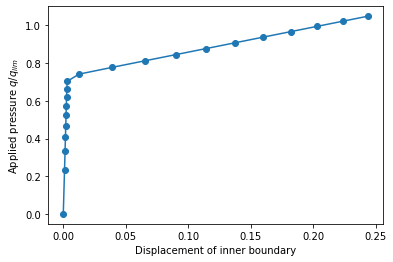

In [ ]:
alpha = np.tan(45*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_45 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 1)

if len(points_on_proc) > 0:
    plot_displacement(results_45)


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.3461538461747102 -1.7442376743512014e-08
C_tang relative error 2.3287691059656234e-09 4.663893389939659e-09
    Residual: 6.193403282196335e-16
p after copy 1.0821069403914617e-11 8.692600919319075e-19 0.0
	rank#0: Time (convex_solving) = 0.00399 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00182 (s)
	rank#0: Time (differentiation) = 0.00930 (s)
	rank#0: Time (return_mapping) = 2.79329 (s)
	rank#0: Time (differentiation_total) = 1.92437 (s)
	rank#0: Time (convex_solving_total) = 0.82583 (s)

nRes0 , 3.688449012023666e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.00041177877838603094 0.0 0.004957556631973069
C_tang 1.3461538461919713 -3.835465491964918e-08
C_tang relative error 5.5158691520362664e-09 1.0830546256648598e-08
    Residual: 9.850356014957099e-13
p after copy 1.9356347515374237e-11 2.316867220788844e-14 0.0
	rank#0: Time (convex_solv

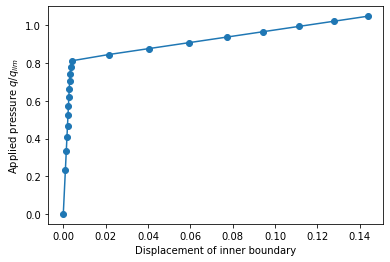

In [ ]:
alpha = np.tan(30*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_30 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 1)

if len(points_on_proc) > 0:
    plot_displacement(results_30)